In [0]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from sklearn.model_selection import KFold, StratifiedKFold
from tensorflow.keras import datasets, layers, models
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os

In [0]:
!rm -rf ./covid/
!rm -rf ./__MACOSX/
!rm -tf ./dataset.zip

rm: invalid option -- 't'
Try 'rm --help' for more information.


In [2]:
!wget https://www.dropbox.com/s/hg42u5y0nsgliw5/dataset%202.zip?dl=0 -O dataset.zip
!unzip dataset.zip
# ! git clone https://github.com/ieee8023/covid-chestxray-dataset.git


--2020-05-10 21:49:26--  https://www.dropbox.com/s/hg42u5y0nsgliw5/dataset%202.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.1, 2620:100:6032:1::a27d:5201
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/hg42u5y0nsgliw5/dataset%202.zip [following]
--2020-05-10 21:49:26--  https://www.dropbox.com/s/raw/hg42u5y0nsgliw5/dataset%202.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucadbf676d0a776cad8579c1839d.dl.dropboxusercontent.com/cd/0/inline/A3dUKBeMBaCa-5ANjP01-aFwwh0bXwlilKUQAUD6C6z4hUy7LiWAS0FxqiFUkqZzeTcrjpwT2mFYqfP6OC5ksv7zJSPvS8A5ti5TGjvUJnvgrSw053NJdn8N2iAGxMjox4c/file# [following]
--2020-05-10 21:49:26--  https://ucadbf676d0a776cad8579c1839d.dl.dropboxusercontent.com/cd/0/inline/A3dUKBeMBaCa-5ANjP01-aFwwh0bXwlilKUQAUD6C6z4hUy7LiWAS0FxqiFUkqZzeTcrjpwT2mFYqfP6OC5ksv7zJSPvS8A5t

In [0]:
!unzip dataset.zip

## Initialization

In [3]:
INIT_LR = 1e-3
EPOCHS = 5
BS = 8

print("[INFO] loading images...")
imagePaths = list(paths.list_images("dataset/"))
data = []
labels = []

for imagePath in imagePaths:
	label = imagePath.split(os.path.sep)[-2]

	image = cv2.imread(imagePath)
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = cv2.resize(image, (224, 224))

	data.append(image)
	labels.append(label)

data = np.array(data) / 255.0
labels = np.array(labels)

lb = LabelBinarizer()
labels = lb.fit_transform(labels)
#labels = to_categorical(labels, num_classes=2)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)
print(testX)
print(testY)

trainAug = ImageDataGenerator(
	rotation_range=15,
	fill_mode="nearest")

[INFO] loading images...
[[[[0.29019608 0.29019608 0.29019608]
   [0.30196078 0.30196078 0.30196078]
   [0.29411765 0.29411765 0.29411765]
   ...
   [0.22745098 0.22745098 0.22745098]
   [0.20392157 0.20392157 0.20392157]
   [0.15294118 0.15294118 0.15294118]]

  [[0.29803922 0.29803922 0.29803922]
   [0.29411765 0.29411765 0.29411765]
   [0.32156863 0.32156863 0.32156863]
   ...
   [0.24705882 0.24705882 0.24705882]
   [0.22352941 0.22352941 0.22352941]
   [0.18431373 0.18431373 0.18431373]]

  [[0.28627451 0.28627451 0.28627451]
   [0.3372549  0.3372549  0.3372549 ]
   [0.34509804 0.34509804 0.34509804]
   ...
   [0.2627451  0.2627451  0.2627451 ]
   [0.25098039 0.25098039 0.25098039]
   [0.20784314 0.20784314 0.20784314]]

  ...

  [[0.10980392 0.10980392 0.10980392]
   [0.09411765 0.09411765 0.09411765]
   [0.09411765 0.09411765 0.09411765]
   ...
   [0.13333333 0.13333333 0.13333333]
   [0.16078431 0.16078431 0.16078431]
   [0.13333333 0.13333333 0.13333333]]

  [[0.09019608 0.090

## CNN

In [0]:
def set_model():
  model = models.Sequential()
  model.add(layers.Conv2D(224, (3, 3), activation='relu', input_shape=(224, 224, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.AveragePooling2D(pool_size=(4, 4)))
  model.add(layers.Flatten(name="flatten"))
  model.add(layers.Dense(64, activation="relu"))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(4, activation="softmax"))
  return model

In [0]:
def run_cnn(model, trainX, testX, trainY, testY, trainAug):
	print("[INFO] compiling model...")
	opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
	model.compile(loss="binary_crossentropy", optimizer=opt,
		metrics=["accuracy"])

	print("[INFO] training head...")
	H = model.fit_generator(
		trainAug.flow(trainX, trainY, batch_size=BS),
		steps_per_epoch=len(trainX) // BS,
		validation_data=(testX, testY),
		validation_steps=len(testX) // BS,
		epochs=EPOCHS)

	print("[INFO] evaluating network...")
	predIdxs = model.predict(testX, batch_size=BS)

	predIdxs = np.argmax(predIdxs, axis=1)
	print(testY.argmax(axis=1))
	print(predIdxs)
	print(lb.classes_)

	print(classification_report(testY.argmax(axis=1), predIdxs,
		target_names=lb.classes_))

	cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
	total = sum(sum(cm))
	acc = (cm[0, 0] + cm[1, 1] + cm[2, 2] + cm[3, 3]) / total

	print(cm)
	print("acc: {:.4f}".format(acc))
 
	return acc;

In [0]:
X = data
# Y = to_categorical(labels, num_classes=4)
Y = labels
EPOCHS = 25
kf = StratifiedKFold(n_splits=5)
accs = []
for trainIdx, testIdx in kf.split(X, labels.argmax(axis=1)):
    #print("%s %s" % (train, test))
    trainX = X[trainIdx]
    testX = X[testIdx]
    trainY = Y[trainIdx]
    testY = Y[testIdx]
    #print(testX)
    #print(testY)
    model = set_model()
    trainAug = ImageDataGenerator(
      rotation_range=15,
      fill_mode="nearest")
    accs.append(run_cnn(model, trainX, testX, trainY, testY, trainAug))
    #clf.fit(X[train],Y[train])
    #print(clf.score(X[test],Y[test]))
print('average accs:', np.mean(accs))

[INFO] compiling model...
[INFO] training head...
Epoch 1/25
30/30 [==============================] - 86s 3s/step - loss: 0.5740 - accuracy: 0.2750 - val_loss: 0.5541 - val_accuracy: 0.3833
Epoch 2/25
30/30 [==============================] - 89s 3s/step - loss: 0.5228 - accuracy: 0.4167 - val_loss: 0.4597 - val_accuracy: 0.4667
Epoch 3/25
30/30 [==============================] - 85s 3s/step - loss: 0.4596 - accuracy: 0.4583 - val_loss: 0.4063 - val_accuracy: 0.4833
Epoch 4/25
30/30 [==============================] - 85s 3s/step - loss: 0.4084 - accuracy: 0.5792 - val_loss: 0.3917 - val_accuracy: 0.5333
Epoch 5/25
30/30 [==============================] - 85s 3s/step - loss: 0.3871 - accuracy: 0.5500 - val_loss: 0.5297 - val_accuracy: 0.4500
Epoch 6/25
30/30 [==============================] - 85s 3s/step - loss: 0.4265 - accuracy: 0.5542 - val_loss: 0.4157 - val_accuracy: 0.5500
Epoch 7/25
30/30 [==============================] - 84s 3s/step - loss: 0.4004 - accuracy: 0.5167 - val_loss: 

## VGG16 (transfer learning)

In [0]:
def set_vgg_model():
	baseModel = VGG16(weights="imagenet", include_top=False,
		input_tensor=Input(shape=(224, 224, 3)))

	headModel = baseModel.output
	headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
	headModel = Flatten(name="flatten")(headModel)
	headModel = Dense(64, activation="relu")(headModel)
	headModel = Dropout(0.5)(headModel)
	headModel = Dense(4, activation="softmax")(headModel)

	model = Model(inputs=baseModel.input, outputs=headModel)

	for layer in baseModel.layers:
		layer.trainable = False
	return model

In [0]:
def run_vgg(model, trainX, testX, trainY, testY, trainAug):
  print("[INFO] compiling model...")
  opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
  model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])

  print("[INFO] training head...")
  H = model.fit_generator(
    trainAug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

  print("[INFO] evaluating network...")
  predIdxs = model.predict(testX, batch_size=BS)

  predIdxs = np.argmax(predIdxs, axis=1)

  print(classification_report(testY.argmax(axis=1), predIdxs,
    target_names=lb.classes_))

  cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
  total = sum(sum(cm))
  acc = (cm[0, 0] + cm[1, 1] + cm[2, 2] + cm[3, 3]) / total

  print(cm)
  print("acc: {:.4f}".format(acc))
 
  return acc;

In [6]:
X = data
# Y = to_categorical(labels, num_classes=4)
Y = labels
EPOCHS = 25
kf = StratifiedKFold(n_splits=5)
accs = []
for trainIdx, testIdx in kf.split(X, labels.argmax(axis=1)):
    #print("%s %s" % (train, test))
    trainX = X[trainIdx]
    testX = X[testIdx]
    trainY = Y[trainIdx]
    testY = Y[testIdx]
    #print(testX)
    #print(testY)
    model = set_vgg_model()
    trainAug = ImageDataGenerator(
      rotation_range=15,
      fill_mode="nearest")
    accs.append(run_vgg(model, trainX, testX, trainY, testY, trainAug))
    #clf.fit(X[train],Y[train])
    #print(clf.score(X[test],Y[test]))
print('average accs:', np.mean(accs))

58892288/58889256 [==============================] - 0s 0us/step
[INFO] compiling model...
[INFO] training head...
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/25
30/30 [==============================] - 145s 5s/step - loss: 0.5929 - accuracy: 0.2875 - val_loss: 0.5347 - val_accuracy: 0.5500
Epoch 2/25
30/30 [==============================] - 145s 5s/step - loss: 0.5329 - accuracy: 0.3958 - val_loss: 0.5018 - val_accuracy: 0.5833
Epoch 3/25
30/30 [==============================] - 145s 5s/step - loss: 0.4938 - accuracy: 0.4875 - val_loss: 0.4730 - val_accuracy: 0.5500
Epoch 4/25
30/30 [==============================] - 146s 5s/step - loss: 0.4614 - accuracy: 0.5958 - val_loss: 0.4446 - val_accuracy: 0.7333
Epoch 5/25
30/30 [==============================] - 146s 5s/step - loss: 0.4459 - accuracy: 0.6125 - val_loss: 0.4335 - val_accuracy: 0.6333
Epoch 6/25
30/30 [==============================] - 146s 5s/step - loss: 0.4255 - accuracy: 0.6083 - val

[INFO] compiling model...
[INFO] training head...
Epoch 1/25
20/20 [==============================] - 87s 4s/step - loss: 0.0735 - accuracy: 0.9812 - val_loss: 0.0799 - val_accuracy: 0.9500
Epoch 2/25
20/20 [==============================] - 85s 4s/step - loss: 0.0603 - accuracy: 0.9812 - val_loss: 0.0572 - val_accuracy: 0.9500
Epoch 3/25
20/20 [==============================] - 85s 4s/step - loss: 0.0655 - accuracy: 0.9750 - val_loss: 0.0579 - val_accuracy: 0.9500
Epoch 4/25
20/20 [==============================] - 85s 4s/step - loss: 0.0626 - accuracy: 0.9750 - val_loss: 0.0822 - val_accuracy: 0.9500
Epoch 5/25
20/20 [==============================] - 85s 4s/step - loss: 0.0718 - accuracy: 0.9750 - val_loss: 0.0549 - val_accuracy: 0.9500
Epoch 6/25
20/20 [==============================] - 85s 4s/step - loss: 0.0770 - accuracy: 0.9750 - val_loss: 0.0851 - val_accuracy: 0.9500
Epoch 7/25
20/20 [==============================] - 85s 4s/step - loss: 0.0614 - accuracy: 0.9750 - val_loss: 

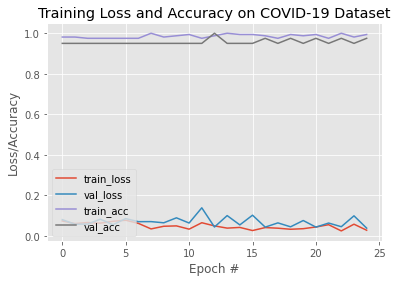

In [0]:
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

print("[INFO] training head...")
H = model.fit_generator(
	trainAug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

predIdxs = np.argmax(predIdxs, axis=1)

print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

# VGG 16 (no tansfer)

In [0]:
# load the VGG16 network, ensuring the head FC layer sets are left
# off
baseModel = VGG16(weights=None, include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base modeld
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
# for layer in baseModel.layers:
# 	layer.trainable = False

In [0]:
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

print("[INFO] training head...")
H = model.fit_generator(
	trainAug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

predIdxs = np.argmax(predIdxs, axis=1)

print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

[INFO] compiling model...
[INFO] training head...
Epoch 1/25
20/20 [==============================] - 296s 15s/step - loss: 0.6932 - accuracy: 0.4062 - val_loss: 0.6931 - val_accuracy: 0.0000e+00
Epoch 2/25
20/20 [==============================] - 295s 15s/step - loss: 0.6931 - accuracy: 0.6000 - val_loss: 0.6931 - val_accuracy: 0.0000e+00
Epoch 3/25
20/20 [==============================] - 295s 15s/step - loss: 0.6931 - accuracy: 0.4563 - val_loss: 0.6931 - val_accuracy: 0.0000e+00
Epoch 4/25
20/20 [==============================] - 295s 15s/step - loss: 0.6931 - accuracy: 0.4750 - val_loss: 0.6931 - val_accuracy: 1.0000
Epoch 5/25
20/20 [==============================] - 294s 15s/step - loss: 0.6931 - accuracy: 0.5437 - val_loss: 0.6931 - val_accuracy: 0.0000e+00
Epoch 6/25
20/20 [==============================] - 293s 15s/step - loss: 0.6931 - accuracy: 0.4875 - val_loss: 0.6931 - val_accuracy: 0.0000e+00
Epoch 7/25
20/20 [==============================] - 293s 15s/step - loss: 0.69

# ResNet101 (transfer learning)

In [0]:
def set_resnet_model():
	baseModel = ResNet101(weights="imagenet", include_top=False,
		input_tensor=Input(shape=(224, 224, 3)))

	headModel = baseModel.output
	headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
	headModel = Flatten(name="flatten")(headModel)
	headModel = Dense(64, activation="relu")(headModel)
	headModel = Dropout(0.5)(headModel)
	headModel = Dense(4, activation="softmax")(headModel)

	model = Model(inputs=baseModel.input, outputs=headModel)

	for layer in baseModel.layers:
		layer.trainable = False
	return model

In [0]:
def run_resnet(model, trainX, testX, trainY, testY, trainAug):
	print("[INFO] compiling model...")
	opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
	model.compile(loss="binary_crossentropy", optimizer=opt,
		metrics=["accuracy"])

	print("[INFO] training head...")
	H = model.fit_generator(
		trainAug.flow(trainX, trainY, batch_size=BS),
		steps_per_epoch=len(trainX) // BS,
		validation_data=(testX, testY),
		validation_steps=len(testX) // BS,
		epochs=EPOCHS)

	print("[INFO] evaluating network...")
	predIdxs = model.predict(testX, batch_size=BS)

	predIdxs = np.argmax(predIdxs, axis=1)

	print(classification_report(testY.argmax(axis=1), predIdxs,
		target_names=lb.classes_))

	cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
	total = sum(sum(cm))
	acc = (cm[0, 0] + cm[1, 1] + cm[2, 2] + cm[3, 3]) / total

	print(cm)
	print("acc: {:.4f}".format(acc))

	N = EPOCHS
	plt.style.use("ggplot")
	plt.figure()
	plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
	plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
	plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
	plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
	plt.title("Training Loss and Accuracy on COVID-19 Dataset")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss/Accuracy")
	plt.legend(loc="lower left")

	return acc

[INFO] compiling model...
[INFO] training head...
Epoch 1/25
30/30 [==============================] - 86s 3s/step - loss: 0.6083 - accuracy: 0.2125 - val_loss: 0.5592 - val_accuracy: 0.2500
Epoch 2/25
30/30 [==============================] - 85s 3s/step - loss: 0.5602 - accuracy: 0.2917 - val_loss: 0.5545 - val_accuracy: 0.2500
Epoch 3/25
30/30 [==============================] - 84s 3s/step - loss: 0.5619 - accuracy: 0.2833 - val_loss: 0.5507 - val_accuracy: 0.4833
Epoch 4/25
30/30 [==============================] - 83s 3s/step - loss: 0.5537 - accuracy: 0.3292 - val_loss: 0.5470 - val_accuracy: 0.4667
Epoch 5/25
30/30 [==============================] - 86s 3s/step - loss: 0.5502 - accuracy: 0.3375 - val_loss: 0.5432 - val_accuracy: 0.4167
Epoch 6/25
30/30 [==============================] - 83s 3s/step - loss: 0.5429 - accuracy: 0.3458 - val_loss: 0.5388 - val_accuracy: 0.4667
Epoch 7/25
30/30 [==============================] - 83s 3s/step - loss: 0.5452 - accuracy: 0.3208 - val_loss: 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                precision    recall  f1-score   support

         covid       0.69      0.60      0.64        15
        normal       0.36      1.00      0.53        15
other bacteria       0.40      0.13      0.20        15
   other viral       0.00      0.00      0.00        15

      accuracy                           0.43        60
     macro avg       0.36      0.43      0.34        60
  weighted avg       0.36      0.43      0.34        60

[[ 9  4  2  0]
 [ 0 15  0  0]
 [ 2 11  2  0]
 [ 2 12  1  0]]
acc: 0.4333
[INFO] compiling model...
[INFO] training head...
Epoch 1/25
30/30 [==============================] - 86s 3s/step - loss: 0.5851 - accuracy: 0.2750 - val_loss: 0.5598 - val_accuracy: 0.2500
Epoch 2/25
30/30 [==============================] - 83s 3s/step - loss: 0.5532 - accuracy: 0.3417 - val_loss: 0.5513 - val_accuracy: 0.2667
Epoch 3/25
30/30 [==============================] - 83s 3s/step - loss: 0.5612 - accuracy: 0.2667 - val_loss: 0.5531 - val_accuracy: 0.2500
Epoch 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                precision    recall  f1-score   support

         covid       0.58      0.73      0.65        15
        normal       0.41      1.00      0.58        15
other bacteria       0.00      0.00      0.00        15
   other viral       0.50      0.13      0.21        15

      accuracy                           0.47        60
     macro avg       0.37      0.47      0.36        60
  weighted avg       0.37      0.47      0.36        60

[[11  3  0  1]
 [ 0 15  0  0]
 [ 5  9  0  1]
 [ 3 10  0  2]]
acc: 0.4667
[INFO] compiling model...
[INFO] training head...
Epoch 1/25
30/30 [==============================] - 86s 3s/step - loss: 0.5960 - accuracy: 0.2792 - val_loss: 0.5623 - val_accuracy: 0.2500
Epoch 2/25
30/30 [==============================] - 82s 3s/step - loss: 0.5620 - accuracy: 0.3167 - val_loss: 0.5554 - val_accuracy: 0.3500
Epoch 3/25
30/30 [==============================] - 82s 3s/step - loss: 0.5636 - accuracy: 0.2750 - val_loss: 0.5545 - val_accuracy: 0.4167
Epoch 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                precision    recall  f1-score   support

         covid       0.50      0.73      0.59        15
        normal       0.54      1.00      0.70        15
other bacteria       0.40      0.27      0.32        15
   other viral       0.00      0.00      0.00        15

      accuracy                           0.50        60
     macro avg       0.36      0.50      0.40        60
  weighted avg       0.36      0.50      0.40        60

[[11  2  2  0]
 [ 0 15  0  0]
 [ 6  5  4  0]
 [ 5  6  4  0]]
acc: 0.5000
[INFO] compiling model...
[INFO] training head...
Epoch 1/25
30/30 [==============================] - 85s 3s/step - loss: 0.5813 - accuracy: 0.3167 - val_loss: 0.5710 - val_accuracy: 0.2500
Epoch 2/25
30/30 [==============================] - 84s 3s/step - loss: 0.5715 - accuracy: 0.2958 - val_loss: 0.5541 - val_accuracy: 0.4333
Epoch 3/25
30/30 [==============================] - 83s 3s/step - loss: 0.5650 - accuracy: 0.2917 - val_loss: 0.5553 - val_accuracy: 0.5500
Epoch 

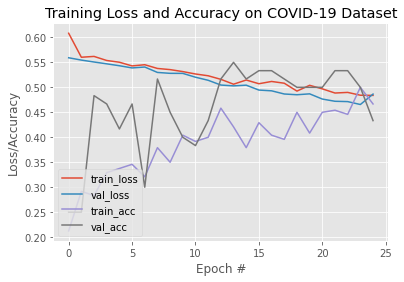

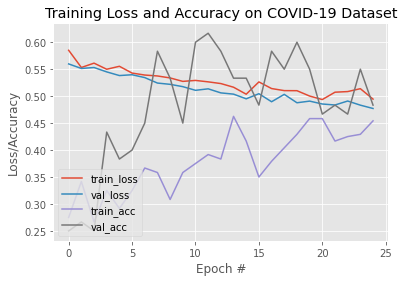

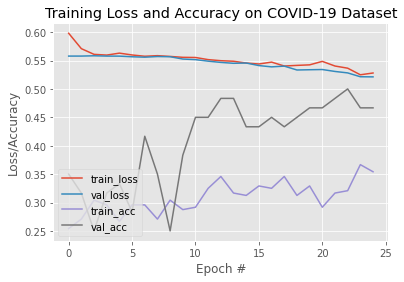

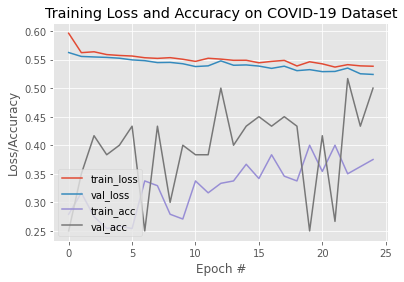

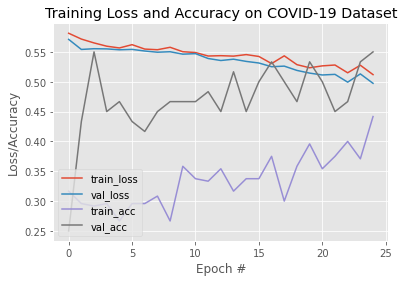

In [10]:
X = data
# Y = to_categorical(labels, num_classes=2)
Y = labels
EPOCHS = 25
kf = StratifiedKFold(n_splits=5)
accs = []
for trainIdx, testIdx in kf.split(X, labels.argmax(axis=1)):
    #print("%s %s" % (train, test))
    trainX = X[trainIdx]
    testX = X[testIdx]
    trainY = Y[trainIdx]
    testY = Y[testIdx]
    #print(testX)
    #print(testY)
    model = set_resnet_model()
    trainAug = ImageDataGenerator(
      rotation_range=15,
      fill_mode="nearest")
    accs.append(run_resnet(model, trainX, testX, trainY, testY, trainAug))
    #clf.fit(X[train],Y[train])
    #print(clf.score(X[test],Y[test]))
print('average accs:', np.mean(accs))

# ResNet101 (no transfer)

In [0]:
baseModel = ResNet101(weights=None, include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

[INFO] compiling model...
[INFO] training head...
Epoch 1/25
20/20 [==============================] - 202s 10s/step - loss: 2.1608 - accuracy: 0.6562 - val_loss: 0.6946 - val_accuracy: 0.5000
Epoch 2/25
20/20 [==============================] - 201s 10s/step - loss: 1.1539 - accuracy: 0.7063 - val_loss: 0.9232 - val_accuracy: 0.5000
Epoch 3/25
20/20 [==============================] - 198s 10s/step - loss: 0.7781 - accuracy: 0.6438 - val_loss: 0.9201 - val_accuracy: 0.5000
Epoch 4/25
20/20 [==============================] - 197s 10s/step - loss: 0.7304 - accuracy: 0.7375 - val_loss: 0.8302 - val_accuracy: 0.5000
Epoch 5/25
20/20 [==============================] - 193s 10s/step - loss: 0.5768 - accuracy: 0.7437 - val_loss: 0.9875 - val_accuracy: 0.5000
Epoch 6/25
20/20 [==============================] - 199s 10s/step - loss: 0.4764 - accuracy: 0.7812 - val_loss: 1.3723 - val_accuracy: 0.5000
Epoch 7/25
20/20 [==============================] - 197s 10s/step - loss: 0.2505 - accuracy: 0.900

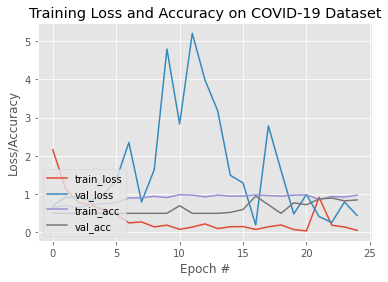

In [0]:
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

print("[INFO] training head...")
H = model.fit_generator(
	trainAug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

predIdxs = np.argmax(predIdxs, axis=1)

print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

# Data Visualization

In [0]:
# !ls 
# import data
metadata_dir = 'covid-chestxray-dataset/metadata.csv'
metadata = pd.read_csv(metadata_dir)
# what info do we have?
print(metadata.columns)
print(np.shape(metadata))

row , col = np.shape(metadata)
data = []
labels = []

# path = 'covid-chestxray-dataset/images/16654_1_1.png'
# image = cv2.imread(path)
# # image = cv2.imread(imagePath)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# cv2.imshow('image',image)
path = 'covid/'
for i in range(row):
  imagePath = 'covid-chestxray-dataset/images/' + metadata.filename[i] 
  image = cv2.imread(imagePath)
  if metadata.finding[i] == 'COVID-19':
    cv2.imwrite(path,image)
#   image = cv2.imread(imagePath)
#   image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#   image = cv2.resize(image, (224, 224))
 
#   data.append(image)
#   if metadata.finding[i] == 'COVID-19':
#     labels.append('covid')
#   else:
#     labels.append('normal')

# print(labels.shape)

In [0]:
print(metadata.finding[41:60], metadata.filename[41:60])

41    COVID-19
42    COVID-19
43    COVID-19
44    COVID-19
45    COVID-19
46    COVID-19
47    COVID-19
48    COVID-19
49    COVID-19
50    COVID-19
51    COVID-19
52    COVID-19
53    COVID-19
54    COVID-19
55    COVID-19
56    COVID-19
57    COVID-19
58        ARDS
59        ARDS
Name: finding, dtype: object 41               1-s2.0-S0929664620300449-gr2_lrg-b.jpg
42               1-s2.0-S0929664620300449-gr2_lrg-c.jpg
43               1-s2.0-S0929664620300449-gr2_lrg-d.jpg
44               1-s2.0-S0929664620300449-gr3_lrg-a.jpg
45               1-s2.0-S0929664620300449-gr3_lrg-b.jpg
46               1-s2.0-S0929664620300449-gr3_lrg-c.jpg
47               1-s2.0-S0929664620300449-gr3_lrg-d.jpg
48                         covid-19-pneumonia-15-PA.jpg
49                          covid-19-pneumonia-15-L.jpg
50                             covid-19-pneumonia-2.jpg
51                          covid-19-pneumonia-7-PA.jpg
52                           covid-19-pneumonia-7-L.jpg
53    radiopae

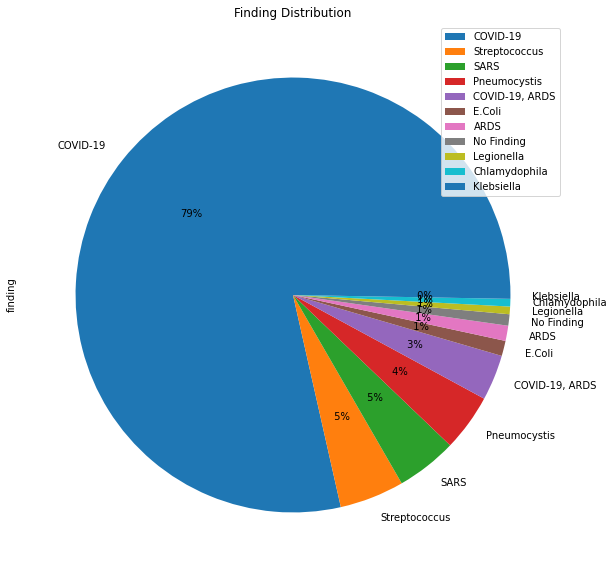

In [0]:
# Finding distribution (nan if unknown)
ax = metadata['finding'].value_counts(dropna=False).plot.pie(y='Finding', legend = True, autopct='%2.0f%%', figsize = (10,10), title = 'Finding Distribution')